In [72]:
%load_ext autoreload
import os, sys, glob
import json
import re
import numpy as np
import pandas as pd
import ast
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavioral/code/utils/')
sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/utils/gentle')

import gentle
from narratives_utils import *
from text_utils import get_pos_tags, get_lemma

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set directories

In [2]:
EXPERIMENT_NAME = 'next-word-prediction'
EXPERIMENT_VERSION = 'pilot-version-04'
TASK = 'black'

base_dir = '/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavioral/'
gentle_dir = os.path.join(base_dir, 'stimuli', 'gentle')
results_dir = os.path.join(base_dir, 'experiments',  EXPERIMENT_NAME, 'results', EXPERIMENT_VERSION, TASK)
preproc_dir = os.path.join(base_dir, 'stimuli', 'preprocessed')

out_dir = os.path.join(base_dir, 'derivatives', EXPERIMENT_NAME, EXPERIMENT_VERSION, TASK)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# for huggingface
cache_dir = '/dartfs/rc/lab/F/FinnLab/tommy/models/huggingface/transformers'

Load transcript

In [3]:
transcript = pd.read_csv(os.path.join(preproc_dir, TASK, f'{TASK}_transcript_preprocessed.csv'))
transcript_words = transcript['Word_Written'].values

# Get data for stories

In [10]:
def load_participant_results(sub_dir, sub):
    # load and filter down to response trials
    df_results = pd.read_csv(os.path.join(sub_dir, f'{sub}_next-word-prediction.csv')).fillna(False)
    prolific_id = list(set(df_results['prolific_id']))
    
    df_results = df_results[df_results['critical_trial']]
    
    # convert string to dictionary
    df_results['response'] = df_results['response'].apply(ast.literal_eval)

    # filter down to the expeirment get the responses
    df_results = df_results[df_results['experiment_phase'] == 'experiment']
    df_results['response'] = [d.get('Q0') for d in df_results['response']]
    
    df_results['transcript_index'] = df_results['transcript_index'].astype(int) - 1
    
    return prolific_id[0], df_results

def add_word_response(dict, key, value):
    
    if key in dict:
        dict[key].append(value)
    else:
        dict[key] = [value]
        
    return dict

Load data for all modalities

In [ ]:
os.environ

In [11]:
MODALITIES = ['audio', 'text']

# modalities_dict = {}

df_results = pd.DataFrame(columns=['modality', 'subject',  'transcript_index', 'response', 'ground_truth'])

for mod in MODALITIES:
    
    # go through each task and get participant data
    sub_dirs = sorted(glob.glob(os.path.join(results_dir, mod, '*sub*')))

    accuracy_stack = []
    transcript_responses = {}
    transcript_accuracy = {}

    for sub_dir in sub_dirs:
        sub = os.path.basename(sub_dir)
        
        prolific_id, results = load_participant_results(sub_dir, sub)
        results['response'] = results['response'].str.lower()
        
        # calculate prediction accuracy
#         accuracy = np.sum(results['current_word'] == results['response']) / len(results['current_word'])
#         accuracy = np.asarray(results['current_word'] == results['response']) #/ len(results['current_word'])
#         accuracy_stack.append(accuracy)
        
        for index, response in results[['transcript_index', 'response']].values:
            
            df_results.loc[len(df_results)] = {
                'modality': mod,
                'subject': sub,
                'transcript_index': index,
                'response': response,
                'ground_truth': transcript_words[index].lower()
            }
#             transcript_responses = add_word_response(transcript_responses, index, response)
            
#             accuracy = np.asarray(response == transcript_words[index])
            
#             transcript_accuracy = add_word_response(transcript_accuracy, index, accuracy)
            
#     modalities_dict[mod] = {
#         'transcript': transcript_words,
#         'accuracy': transcript_accuracy, #np.stack(accuracy_stack),
#         'responses': transcript_responses
#     }


# Check variation in first letter

In [350]:
df_stack = []

for mod in MODALITIES:
    
    transcript_words = modalities_dict[mod]['transcript']
    
    phoneme_counts = []
    phoneme_accuracy = []
    phoneme_wrong_accuracy = []
    phoneme_wrong_variation = []
    
    for idx, responses in modalities_dict[mod]['responses'].items():
        # grab the first letter of the provided word
        predicted_phoneme = [word[:1] for word in responses]
        unique, counts = np.unique(predicted_phoneme, return_counts=True)
        
        phoneme_counts.append(variation)
        
        
        variation = len(unique) / len(responses)
        
        all_accuracy = np.asarray([word[:1] == transcript_words[idx][:1] for word in responses])
        all_accuracy = np.sum(all_accuracy) / len(all_accuracy)
        
        phoneme_accuracy.append(all_accuracy)
        
        
        # now look at wrong responses
        wrong_responses = np.where(np.asarray(responses) != transcript_words[idx])[0]
        
        if len(wrong_responses) >= 1:
            predicted_wrong_responses = [word[:1] for word in np.asarray(responses)[wrong_responses].tolist()]

            wrong_unique = np.unique(predicted_wrong_responses)
            wrong_variation = len(wrong_unique) / len(wrong_responses)

            wrong_accuracy = np.asarray([phoneme == transcript_words[idx][:1] for phoneme in predicted_wrong_responses])
            wrong_accuracy = np.sum(wrong_accuracy) / len(wrong_accuracy)
        else:
            wrong_variation = np.nan
            wrong_accuracy = np.nan
        
        phoneme_wrong_accuracy.append(wrong_accuracy)
        phoneme_wrong_variation.append(wrong_variation)
        

        
    modalities_dict[mod]['phoneme_counts'] = phoneme_counts.copy()
        
    df = pd.DataFrame(
        np.stack((np.repeat(mod, len(phoneme_counts)),
                  np.asarray(phoneme_counts),
                  np.asarray(phoneme_accuracy),
                  np.asarray(phoneme_wrong_variation), 
                  np.asarray(phoneme_wrong_accuracy))).T, 
        columns=['modality', 'phoneme_counts', 'phoneme_accuracy', 'wrong_variation', 'wrong_accuracy']
    )
    
    df_stack.append(df)
    
df_stack = pd.concat(df_stack).reset_index()
df_stack['phoneme_counts'] = df_stack['phoneme_counts'].astype(float)
df_stack['phoneme_accuracy'] = df_stack['phoneme_accuracy'].astype(float)
df_stack['wrong_accuracy'] = df_stack['wrong_accuracy'].astype(float)
df_stack['wrong_variation'] = df_stack['wrong_variation'].astype(float)

Plot wrong answers

Text(0.5, 1.0, 'Phoneme variation by condition - wrong answers')

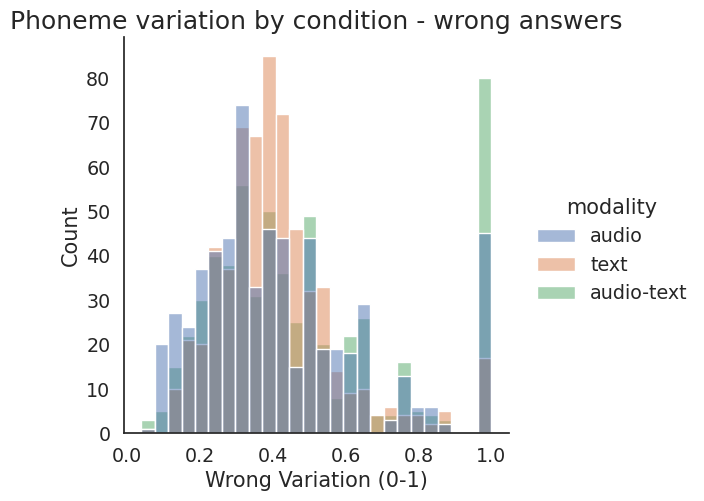

In [339]:
sns.displot(df_stack, x="wrong_variation", hue="modality", kind='hist', alpha=0.5)
plt.xlabel('Wrong Variation (0-1)')
plt.title('Phoneme variation by condition - wrong answers')

Text(0.5, 1.0, 'Phoneme accuracy by condition - wrong answers')

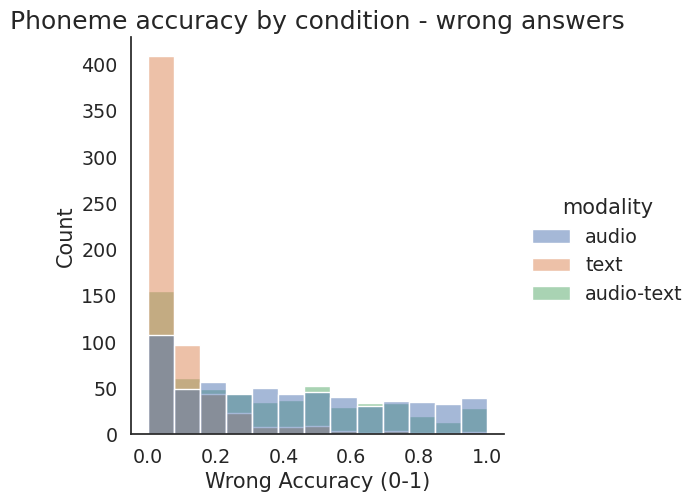

In [338]:
sns.displot(df_stack, x="wrong_accuracy", hue="modality", kind='hist', alpha=0.5)
plt.xlabel('Wrong Accuracy (0-1)')
plt.title('Phoneme accuracy by condition - wrong answers')

Text(0.5, 1.0, 'Phoneme accuracy by condition - Before')

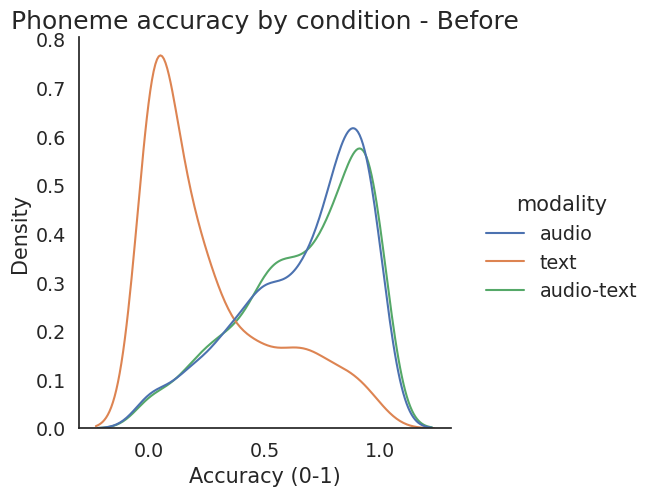

In [905]:
sns.displot(df_stack, x="phoneme_accuracy", hue="modality", kind='kde')
plt.xlabel('Accuracy (0-1)')
plt.title('Phoneme accuracy by condition - Before')

Text(0.5, 1.0, 'Phoneme variation by condition - Before')

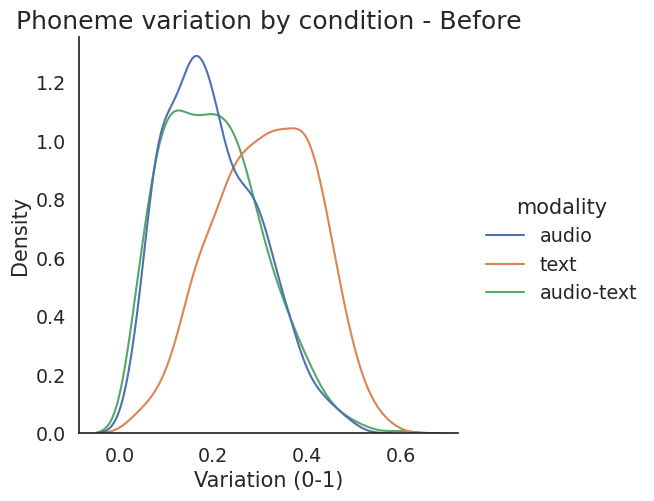

In [883]:
sns.displot(df_stack, x="phoneme_counts", hue="modality", kind='kde')
plt.xlabel('Variation (0-1)')
plt.title('Phoneme variation by condition - Before')

# Find overlap in modality distributions

In [51]:
def get_phoneme_counts(response):
    predicted_phoneme = [word[:1] for word in response]
    unique, counts = np.unique(predicted_phoneme, return_counts=True) 
    return unique, counts

In [52]:
def get_phoneme_stats(responses, ground_truth):
    
    phonemes, counts = get_phoneme_counts(responses)
    
    # get the variation in responses
    # this is the number of unique phonemes over the number of responses 
    # 0 = less variation, 
    # 1 = more varation variation
    variation = len(phonemes) / len(responses)
    
    # number of correct
    accuracy = np.asarray([word[:1] == ground_truth[:1] for word in responses])
    accuracy = np.sum(accuracy) / len(accuracy)
    
    # get wrong answers
    wrong_idxs = np.where(np.asarray(responses) != ground_truth)[0]
    wrong_responses = np.asarray(responses)[wrong_idxs].tolist()
    
    wrong_phonemes, wrong_counts = get_phoneme_counts(wrong_responses)
    
    try:
    
        wrong_variation = len(wrong_unique) / len(wrong_responses)

        wrong_accuracy = np.asarray([word[:1] == ground_truth[:1] for word in wrong_responses])
        wrong_accuracy = np.sum(wrong_accuracy) / len(wrong_accuracy)
    except:
        wrong_variation = np.nan
        wrong_accuracy = np.nan
    
    
    return (phonemes, counts, variation, accuracy), (wrong_phonemes, wrong_counts, wrong_variation, wrong_accuracy)
    
#     # look at wrong responses 
#     wrong_idxs = np.where(np.asarray(responses) != ground_truth)[0]
#     wrong_responses = 
    
#     if len(wrong_responses) >= 1:
#         predicted_wrong_responses = [word[:1] for word in np.asarray(responses)[wrong_idxs].tolist()]

#         wrong_unique = np.unique(predicted_wrong_responses)
#         wrong_variation = len(wrong_unique) / len(wrong_responses)

#         wrong_accuracy = np.asarray([phoneme == transcript_words[idx][:1] for phoneme in predicted_wrong_responses])
#         wrong_accuracy = np.sum(wrong_accuracy) / len(wrong_accuracy)
#     else:
#         wrong_variation = np.nan
#         wrong_accuracy = np.nan

In [1064]:
audio_response 

['right',
 'road',
 'road',
 'really',
 'road',
 'road',
 'real',
 'road',
 'race',
 'real',
 'road',
 'really',
 'really big ',
 'road',
 'regular',
 'real',
 'road',
 'rural',
 'road',
 'road',
 'rich',
 'really',
 'long',
 'radio',
 'road']

In [1072]:
audio_wrong

(array(['c', 'h', 'i', 'o', 's'], dtype='<U1'),
 array([1, 1, 1, 1, 2]),
 0.5,
 0.16666666666666666)

In [1934]:
fisher_exact(np.stack([audio_dist, text_dist]))

(nan, 1.0)

In [53]:
def compare_frequency_correct(correct, a, b):
    
    union = np.union1d(text_wrong[0],audio_wrong[0])
    
    correct_idx = np.where(union != correct)[0]
    
    if len(a[0]):
        a_correct_idx = np.where(a[0] == correct)[0]
        a_incorrect_idx = np.where(a[0] != correct)[0]
        
        if len(a_correct_idx):
            a_correct = a[1][a_correct_idx][0]
        else:
            a_correct = 0
            
        if len(a_incorrect_idx):
            a_incorrect = np.sum(a[1][a_incorrect_idx])
        else:
            a_incorrect = 0
    else:
        a_correct = 0
        a_incorrect = 0
        
    if len(b[0]):
        b_correct_idx = np.where(b[0] == correct)[0]
        b_incorrect_idx = np.where(b[0] != correct)[0]
        
        if len(b_correct_idx):
            b_correct = b[1][b_correct_idx][0]
        else:
            b_correct = 0
        
        if len(b_incorrect_idx):
            b_incorrect = np.sum(b[1][b_incorrect_idx])
        else:
            b_incorrect = 0
    else:
        b_correct = 0
        b_incorrect = 0
    
    return (a_correct+1, a_incorrect+1), (b_correct+1, b_incorrect+1)

In [92]:
from scipy.stats import ttest_ind, f_oneway
from scipy.stats import chisquare, fisher_exact, power_divergence

## different ways to threshold
threshold = lambda x: len(x) < 8
max_threshold = lambda x: (max(x) / sum(x)) < 0.7
pval_threshold = lambda x: x > 0.05
number_threshold = lambda x: np.sum(x) >= 5 # and np.sum(x) <= 2
item_threshold = lambda x,y: abs(x-y) <= 8


# set up dataframes
response_idxs = sorted(df_results['transcript_index'].unique())
valid_idxs = []

df_valid = pd.DataFrame(
    columns=['idx', 'modality', 'phonemes', 'counts', 'variation', 'accuracy']
)

for idx in response_idxs:
    
    # get ground truth word
    ground_truth = transcript_words[idx]
    correct_phoneme = ground_truth[:1]
    
    # get responses for each
    
    audio_response = df_results[(df_results['modality'] == 'audio') & (df_results['transcript_index'] == idx)]['response'].tolist()
    text_response = df_results[(df_results['modality'] == 'text') & (df_results['transcript_index'] == idx)]['response'].tolist()
#     audio_response = modalities_dict['audio']['responses'][idx]
#     text_response = modalities_dict['text']['responses'][idx]
#     audio_text_response = modalities_dict['audio-text']['responses'][idx]
    
    # phonemes, counts, variation, accuracy
    audio_stats, audio_wrong = get_phoneme_stats(audio_response, ground_truth)
    text_stats, text_wrong = get_phoneme_stats(text_response, ground_truth)
#     audio_text_stats, audio_text_wrong = get_phoneme_stats(audio_text_response, ground_truth)
    
    audio_dist, text_dist =  compare_frequency_correct(correct_phoneme, audio_wrong, text_wrong)
    
    stat, pval = fisher_exact(np.stack([audio_dist, text_dist]), alternative='two-sided')
    
#     stat, pval = chisquare(audio_dist, text_dist)
    
    item_bool = np.all([item_threshold(x,y) for x, y in zip(audio_dist, text_dist)])
    
#     if not (number_threshold(audio_wrong[1]) and number_threshold(text_wrong[1])):
#         continue

    if np.isnan(pval):
        pval=0
    
#     lengths_equal = (threshold(audio_stats[1]) and 
#                      threshold(text_stats[1]) and
#                      threshold(audio_text_stats[1]))
    
#     max_equal = (max_threshold(audio_stats[1]) and 
#                  max_threshold(text_stats[1]) and
#                  max_threshold(audio_text_stats[1])
#                 )
    
#     if (audio_dist[0] <= text_dist[0]):
    if pval_threshold(pval): # and item_bool: # and max_equal:
#         print (audio_dist, text_dist)
        
        df_valid.loc[len(df_valid)] = [idx, 'audio', *audio_wrong]
        df_valid.loc[len(df_valid)] = [idx, 'text', *text_wrong]
#         df_valid.loc[len(df_valid)] = [idx, 'audio_text', *audio_text_wrong]
        

In [93]:
len(np.unique(df_valid['idx'])) / len(response_idxs)

0.5513866231647635

In [61]:
sns.displot(df_valid, x='variation', hue='modality', kind='kde')
plt.xlabel('Variation (0-1)')
plt.title('Wrong answers variation - After Fishers Exact >0.15 (40% of words left)')

NameError: name 'sns' is not defined

Text(0.5, 1.0, 'Phoneme accuracy - Fishers Exact >0.15 (40% of words left)')

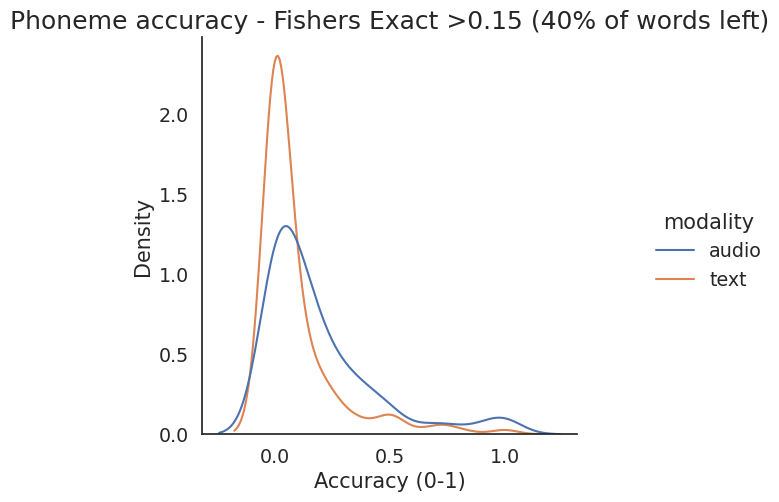

In [3259]:
sns.displot(df_valid, x='accuracy', hue='modality', kind='kde')
plt.xlabel('Accuracy (0-1)')
plt.title('Phoneme accuracy - Fishers Exact >0.15 (40% of words left)')

# Test transformer predictions

In [82]:
import torch
from torch.nn import functional as F
from scipy.special import rel_entr
from scipy import stats

def get_transformer_model(model_name, cache_dir=None, add_prefix_space=False):
    '''
    Use a model from the sentence-transformers library to get
    sentence embeddings. Models used are trained on a next-sentence
    prediction task and evaluate the likelihood of S2 following S1.
    '''
    # set the path of where to download models
    # this NEEDS to be run before loading from transformers
    if cache_dir:
        os.environ['TRANSFORMERS_CACHE'] = cache_dir
    from transformers import AutoTokenizer, AutoModelForCausalLM

    # load a tokenizer and a model
    tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=add_prefix_space)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    
    return tokenizer, model

def get_model_prediction(inputs, model, tokenizer, out_fn=None):
    
    tokens = tokenizer(inputs, return_tensors="pt")
    
    with torch.no_grad():
        logits = model(**tokens).logits[:, -1, :]
    
    probs = F.softmax(logits, dim=-1)
    pred_id = logits.argmax().item()
    pred_word = tokenizer.decode(pred_id)
    pred_prob = probs.max()
    
    # if we provide we save logits out
    if out_fn:
        torch.save(logits, out_fn)
    
    return pred_word, pred_prob, probs

def get_segment_indices(n_words, window_size):
    
    temp_window = 0
    indices = [
        np.arange(i-window_size, i) if i > window_size else np.arange(0, i)
        for i in range(1, n_words)
    ]
    return indices

def process_transcript(transcript, model, tokenizer, window_size, transcript_name, out_dir=None):
    
    prev_dist = None
    kl_divergence = None
    segments = get_segment_indices(n_words=len(transcript), window_size=window_size)
    df = pd.DataFrame([np.concatenate((np.array([transcript[0]]), np.repeat(np.nan, 3)))],
        columns=['predicted_word', 'probability', 'entropy', 'kl_divergence'])
    
    if out_dir and not os.path.exists(out_dir):
        # add the window size to the name
        out_dir = os.path.join(out_dir, f'window-size-{window_size}')
        os.makedirs(out_dir)
        
    out_fn = None
    
    for i, seg in enumerate(segments):
        inputs = transcript[seg].tolist()
        inputs = ' '.join(inputs)
        
        if out_dir:
            out_fn = os.path.join(out_dir, f'{transcript_name}_window-size-{window_size}_logits-{str(i).zfill(5)}.pt')
        
        word, prob, dist = get_model_prediction(inputs=inputs, model=model, tokenizer=tokenizer, out_fn=out_fn)
        entropy = stats.entropy(dist, axis=-1)[0]

        # set as previous distribution
        if not i or prev_dist is None:
            prev_dist = dist
        else:
            kl_divergence = rel_entr(dist, prev_dist).sum()

        df.loc[len(df)] = {
            'predicted_word': word,
            'probability': prob.item(),
            'entropy': entropy,
            'kl_divergence': kl_divergence.item() if kl_divergence is not None else None,
        }
        print (f'Processed segment {i+1}/{len(segments)}')
    return df

Get the tokenizer and model for GPT2

In [81]:
tokenizer, model = get_transformer_model(model_name='gpt2', cache_dir=cache_dir)

Ignored unknown kwargs option trim_offsets


In [7]:
window_size = 100
# words = transcript['Word_Written'].values
model_out_dir = os.path.join(base_dir, 'derivatives', 'model-predictions', TASK, 'gpt2')

# df = process_transcript(transcript=transcript, model=model, tokenizer=tokenizer, window_size=window_size, transcript_name=f'task-{TASK}', out_dir=model_out_dir)

out_fn = f'task-{TASK}_gpt2-predictions_context-{window_size}.csv'
df.to_csv(out_fn)



NameError: name 'df' is not defined

# Process participant data

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

Trim to be only the valid indices from phonemes

In [3260]:
valid_idxs = np.unique(df_valid['idx'])
df_valid_results =  df_results[df_results['transcript_index'].isin(valid_idxs)].reset_index(drop=True)
df_valid_results['accuracy'] = df_valid_results['response'] == df_valid_results['ground_truth']
df_valid_results['accuracy'] = df_valid_results['accuracy'].astype(int)

In [3261]:
df_valid_results.to_csv(os.path.join(out_dir, f'valid-results-accuracy.csv'), index=False)

Now generate accuracy per participant

In [3235]:
df_accuracy = df_valid_results.groupby(['modality', 'subject'])['accuracy'].mean().reset_index()

In [3236]:
f_oneway(*[df_accuracy[df_accuracy['modality'] == mod]['accuracy'] for mod in np.unique(df_accuracy['modality'])])




F_onewayResult(statistic=34.33852628916861, pvalue=1.882820513691619e-08)

In [3237]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df_accuracy['accuracy'], df_accuracy['modality'])
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")

tbl

group1,group2,stat,pval,pval_corr,reject
audio,text,5.8599,0.0,0.0,True


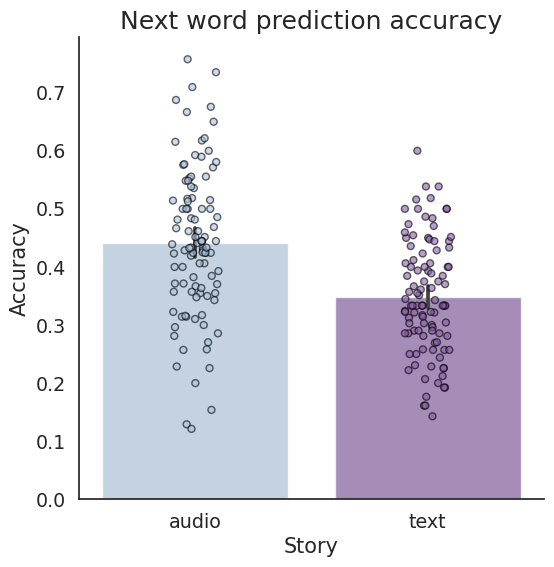

In [3238]:
sns.set(style='white', rc={'figure.figsize':(6,6), "axes.titlesize":18}, font_scale=1.25)

ax = sns.barplot(data=df_accuracy, x='modality', y='accuracy', palette='BuPu', alpha=0.75) #, kwargs=dict(alpha=0.5))
ax = sns.stripplot(data=df_accuracy, x='modality', y='accuracy', palette='BuPu', size=5, edgecolor='black', linewidth=1,  dodge=True, alpha=0.6, ax=ax)
plt.xlabel('Story')
plt.ylabel('Accuracy')
plt.title('Next word prediction accuracy')
# plt.ylim(0, 0.4)

sns.despine()


# Plot example word distributions

In [501]:
import random

IndexError: list index out of range

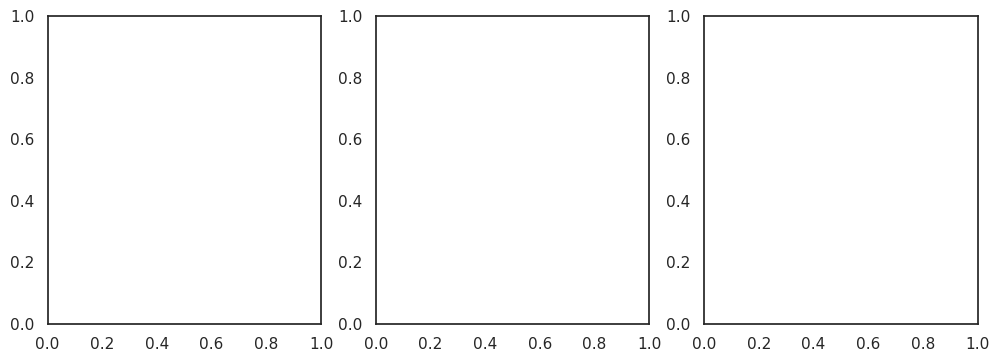

In [2544]:
sns.set(style='white', rc={'figure.figsize':(12,4), "axes.titlesize":12})

n_indices = 3

fig, axes = plt.subplots(1, n_indices)
axes = axes.flatten()
counter = 0

# for task in tasks:
task = tasks[1]

cmap = sns.color_palette("BuPu",n_indices) #Splitting the palette in the same amount of numbers bins


task_transcript = modalities_dict[mod]['transcript']
task_responses = modalities_dict[mod]['responses']
response_indices = random.sample(list(task_responses.keys()), n_indices)

for ax, cm, idx in zip(axes, cmap, response_indices):
    sns.histplot(task_responses[idx], stat="probability", ax=ax, color=cm, alpha=0.8)
    ax.set_ylabel('Probability')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    
    sns.despine()
    ax.title.set_text(f'Correct word: {task_transcript[idx]}')
    counter += 1
    
plt.tight_layout()
plt.suptitle(f'Behavioral predictions - {task.capitalize()}', y=1.05)

# Compare responses to GPT

In [3204]:
from scipy.stats import pearsonr

window_size = 100
model_fn = f'task-{TASK}_gpt2-predictions_context-{window_size}.csv'
df_model = pd.read_csv(model_fn)

In [94]:
df_comparison = pd.DataFrame(
    columns=['modality', 'ground_truth', 'prob_human', 'prob_model', 'pred_human', 'pred_model', 'entropy', 'kl_divergence']
)

valid_idxs = np.unique(df_valid['idx'])

# valid_idxs = response_idxs

for mod in MODALITIES:
    transcript = modalities_dict[mod]['transcript']
    modality_responses = modalities_dict[mod]['responses']
    
    response_idxs = list(modality_responses.keys())
    
    for idx in valid_idxs: #response_idxs:

        unique, counts = np.unique(modality_responses[idx], return_counts=True)
        probs = counts / sum(counts)

        ground_truth = transcript[idx]

        pred_human = unique[probs.argmax()]
        pred_model = df_model.loc[idx]['predicted_word']

        prob_human = probs.max()
        prob_model = df_model.loc[idx]['probability']

        df_comparison.loc[len(df_comparison)] = {
            'modality' : mod,
            'ground_truth': ground_truth,
            'prob_human': prob_human,
            'prob_model': prob_model,
            'pred_human': pred_human,
            'pred_model': pred_model,
            'entropy': df_model.loc[idx]['entropy'],
            'kl_divergence': df_model.loc[idx]['kl_divergence'],
        }
        
df_comparison['pred_model'] = df_comparison['pred_model'].str.strip()    



NameError: name 'modalities_dict' is not defined

In [3278]:
df_comparison.to_csv(os.path.join(out_dir, f'valid-results_model-top-prob.csv'))

Check distributions of human probabilities across modalities

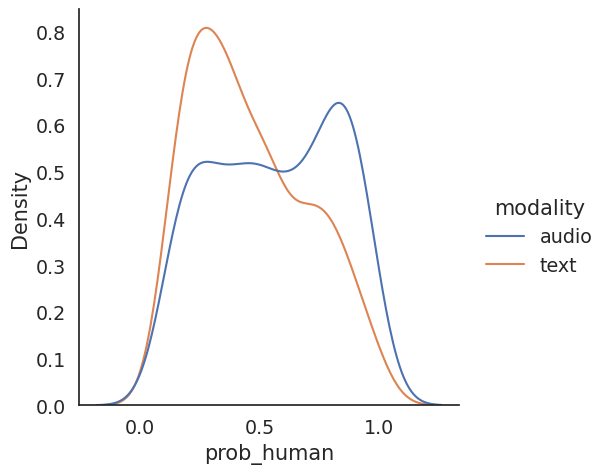

In [3264]:
sns.displot(data=df_comparison, x="prob_human", hue="modality", kind="kde")

Check the correlation between human and model predictions for each modality

In [3281]:
from scipy.stats import pearsonr, spearmanr

for mod in MODALITIES:
    
    df_modality = df_comparison[df_comparison['modality'] == mod]

    r, pval = pearsonr(df_modality['prob_human'], df_modality['prob_model'])
    
    print (mod, r, pval)

audio 0.3803102851583819 2.2577550531380408e-10
text 0.4774362581033449 3.2953666251106184e-16


In [1983]:
colors = df_comparison['prob_human'] - df_comparison['prob_model']
cmap = sns.color_palette("BuPu",9) #Splitting the palette in the same amount of numbers bins

audio 0.3803102851583819 2.2577550531380408e-10
text 0.4774362581033449 3.2953666251106184e-16


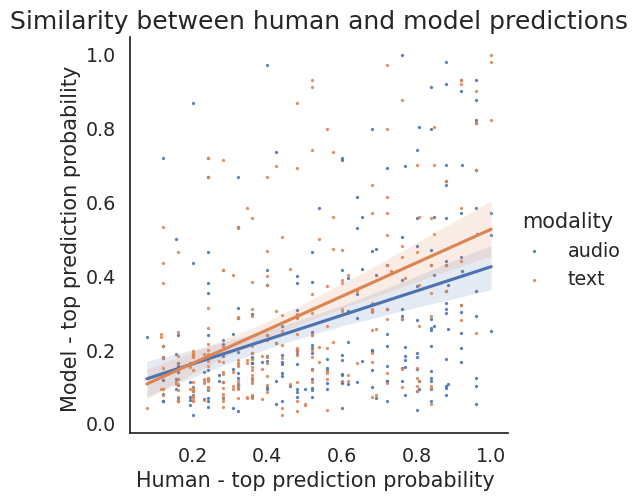

In [3276]:
sns.lmplot(data=df_comparison, x="prob_human", y="prob_model", hue='modality',  scatter_kws={"s": 2}) #, scatter=False, label=f'Pearson r = {r:.2f}', color=".1", ax=ax)
plt.title('Similarity between human and model predictions')
plt.ylabel('Model - top prediction probability ')
plt.xlabel('Human - top prediction probability ')

for mod in MODALITIES:
    
    df_modality = df_comparison[df_comparison['modality'] == mod]

    r, pval = pearsonr(df_modality['prob_human'], df_modality['prob_model'])
    
    print (mod, r, pval)

# Alignment

1. correlation of human probability and model probability of the most probable human word (e.g., dog) --> pull out probability of that word from model distribution
2. KL divergence over human distribution and model distribution (normalized to the words humans predicted)

In [83]:
def get_word_prob(tokenizer, word, logits):
    
    # use the tokenizer to find the index of each word, 
    idxs = tokenizer(word)['input_ids']
    probs = F.softmax(logits, dim=-1)
    word_prob = probs[:, idxs]
    
    return word_prob.squeeze().mean().item()
    

In [84]:
tokenizer, model = get_transformer_model(model_name='gpt2', cache_dir=cache_dir, add_prefix_space=True)

Ignored unknown kwargs option trim_offsets


In [95]:
import torch

logits_dir = os.path.join(model_out_dir, f'window-size-{window_size}')

# here prob model is the probability of the top human word

df_human_preds = pd.DataFrame(
    columns=['modality', 'prob_human', 'prob_model', 'kl_divergence']
)

response_idxs = sorted(df_results['transcript_index'].unique())

# response_idxs = df_valid['idx'].unique()

for mod in MODALITIES:
    
    df_mod = df_results[df_results['modality']==mod]
    
    for idx in response_idxs:
        
        responses = df_mod[df_mod['transcript_index'] == idx]['response'].tolist()

        unique, counts = np.unique(responses, return_counts=True)
        probs_dist_human = counts / sum(counts)
        
        pred_human = unique[probs_dist_human.argmax()]

        top_prob_human = probs_dist_human.max()

        # load logits
        logits_fn = glob.glob(os.path.join(logits_dir, f'*{str(idx).zfill(5)}*'))[0]
        logits = torch.load(logits_fn)

#         top_prob_model = get_word_prob(tokenizer, word=pred_human, logits=logits)
        
        prob_dist_model = np.asarray([get_word_prob(tokenizer, word=word, logits=logits) for word in unique])
        
        # normalize to the samples
        prob_dist_model = prob_dist_model / prob_dist_model.sum()
        top_prob_model = prob_dist_model[probs_dist_human.argmax()]
        
#         stat, pval = kstest(probs_dist_human, prob_dist_model)
        
        kl_divergence = rel_entr(prob_dist_model, probs_dist_human).sum()
        
        df_human_preds.loc[len(df_human_preds)] = {
            'modality': mod,
            'prob_human': top_prob_human,
            'prob_model': top_prob_model,
            'kl_divergence': kl_divergence
        }

In [90]:
df_human_preds.to_csv(os.path.join(out_dir, f'valid-results_human-model-top-prob.csv'))

Plot KL divergence

lower numbers mean better fits

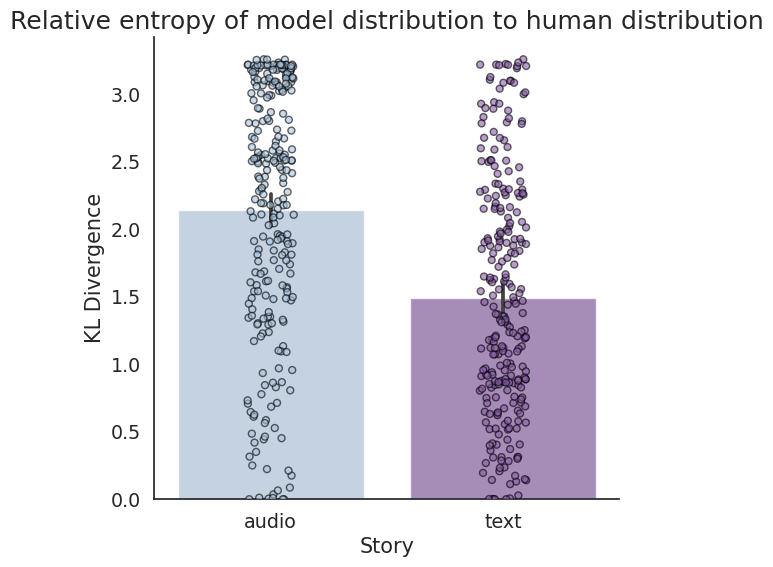

In [77]:
sns.set(style='white', rc={'figure.figsize':(6,6), "axes.titlesize":18}, font_scale=1.25)

ax = sns.barplot(data=df_human_preds, x='modality', y='kl_divergence', palette='BuPu', alpha=0.75) #, kwargs=dict(alpha=0.5))
ax = sns.stripplot(data=df_human_preds, x='modality', y='kl_divergence', palette='BuPu', size=5, edgecolor='black', linewidth=1,  dodge=True, alpha=0.6, ax=ax)
plt.xlabel('Story')
plt.ylabel('KL Divergence')
plt.title('Relative entropy of model distribution to human distribution')
# plt.ylim(0, 0.4)

sns.despine()


In [75]:
from scipy.stats import pearsonr

audio
(0.22855649664075112, 1.0455643326988304e-08)
text
(0.3505333928461232, 3.669287189833377e-19)


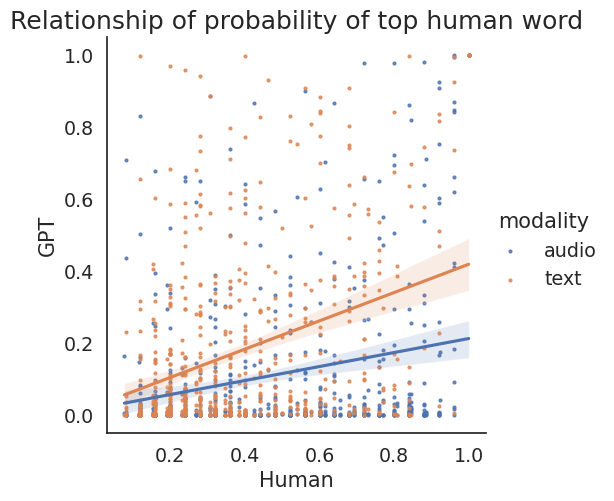

In [96]:
sns.lmplot(data=df_human_preds, x="prob_human", y="prob_model", hue='modality',  scatter_kws={"s": 4}) #, scatter=False, label=f'Pearson r = {r:.2f}', color=".1", ax=ax)
plt.title('Relationship of probability of top human word')
plt.ylabel('GPT')
plt.xlabel('Human')

for mod in MODALITIES:
    print (mod)
    df_mod = df_human_preds[df_human_preds['modality'] == mod]
    print(pearsonr(df_mod['prob_human'], df_mod['prob_model']))
#     sys.exit(0)


In [2781]:
f_oneway(*[df_human_preds[df_human_preds['modality'] == mod]['prob_human'] for mod in np.unique(df_human_preds['modality'])])




F_onewayResult(statistic=25.028780411842607, pvalue=2.9236963887791237e-11)

In [3248]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df_human_preds['prob_human'], df_human_preds['modality'])
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")

tbl

group1,group2,stat,pval,pval_corr,reject
audio,text,0.4246,0.6715,0.6715,False


# Accuracy

1. raw binarized accuracy (useful but not overly informative) --> number of hits (accurate predictions) normalized by number of predictions
2. continuous accuracy --> cosine similarity between contextual embeddings of predicted word and true word

# Variation 

1. average number of unique words predicted per word
2. variance of cosine similarity of the predicted set of words

In [ ]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist

In [3329]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_bert_model(model_name='sentence-transformers/all-MiniLM-L6-v2', cache_dir=None):
    '''
    Use a model from the sentence-transformers library to get
    sentence embeddings. Models used are trained on a next-sentence
    prediction task and evaluate the likelihood of S2 following S1.
    '''
    # set the path of where to download models
    # this NEEDS to be run before loading from transformers
    if cache_dir:
        os.environ['TRANSFORMERS_CACHE'] = cache_dir
    from transformers import AutoTokenizer, AutoModel

    # Load model from HuggingFace Hub
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModel.from_pretrained(model_name)
    
    return tokenizer, model

def get_bert_encoding(model, tokenizer, sentences):

    # Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    
    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    
    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings

def extract_word_id_indices(word_ids, mask):
    
    # turn none ids into -1
    ids = torch.tensor([id if id is not None else -1 for id in word_ids])
    
    # mask based on our context tokens
    mask = torch.logical_and(ids >=0, ~torch.isin(ids, mask))
    
    return mask

def extract_response_embeddings(tokenizer, model, sentences, mask):
    
    # Tokenize full sentences -- this is what we will run through the model
    encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    
    # generate mask of the embeddings we're interested in
    id_indices = [extract_word_id_indices(encoded_inputs.word_ids(i), mask) for i in range(len(encoded_inputs['input_ids']))]
    id_indices = torch.stack(id_indices)
    
    with torch.no_grad():
        model_output = model(**encoded_inputs)
        
    # then mask each embedding by the words of interest, take the mean across them
    embeddings = torch.stack([embeddings[mask].sum(0) for embeddings, mask in zip(model_output['last_hidden_state'], id_indices)])
    
    return embeddings

Load BERT

In [3136]:
# load bert model
bert_tokenizer, bert_model = get_bert_model(model_name='bert-base-uncased', cache_dir=cache_dir)

Go through each index and run through BERT

In [3332]:
from scipy.spatial.distance import pdist, cdist

sentence_window = 25

# generate segments at the window size
segments = get_segment_indices(n_words=len(transcript), window_size=sentence_window)

df_bert_responses = pd.DataFrame(
    columns=['modality', 'transcript_index', 'n_unique', 'avg_cosine_responses', 'std_cosine_responses', 'avg_cosine_gt', 'std_cosine_gt']
)


for mod in MODALITIES:
    for idx in valid_idxs:

        # get responses for the current index
        df_subset = df_valid_results[
            (df_valid_results['modality'] == mod) &
            (df_valid_results['transcript_index'] == idx)
        ]

        responses = df_subset['response'].tolist()
        
        unique, unique_idxs = np.unique(responses, return_index=True)
        
        # get the current segment and join it together
        sentence_context = transcript[segments[current_index-1]]
        context_indices = torch.arange(len(sentence_context))

        # join and add responses
        sentence_context = ' '.join(sentence_context)
        response_sentences = [f'{sentence_context} {word}' for word in responses]
        
        ground_truth_sentence = [f'{sentence_context} {transcript[idx]}']

        response_embeddings = extract_response_embeddings(bert_tokenizer, bert_model, response_sentences, context_indices)
        ground_truth_embedding = extract_response_embeddings(bert_tokenizer, bert_model, ground_truth_sentence, context_indices)
        
        # calculate variation in response similarity
        avg_response_similarity = np.nanmean(1 - pdist(response_embeddings[unique_idxs], metric='cosine'))
        
        std_response_similarity = np.nanstd(1 - pdist(response_embeddings[unique_idxs], metric='cosine'))
        
        # response similarity to ground truth
        avg_response_ground_truth_similarity = np.nanmean(1 - cdist(response_embeddings[unique_idxs], ground_truth_embedding, metric='cosine'))
        
        std_response_ground_truth_similarity = np.nanstd(1 - cdist(response_embeddings[unique_idxs], ground_truth_embedding, metric='cosine'))
        
        df_bert_responses.loc[len(df_bert_responses)] = {
            'modality': mod,
            'transcript_index': idx,
            'n_unique': len(unique),
            'avg_cosine_responses': avg_response_similarity,
            'std_cosine_responses': std_response_similarity,
            'avg_cosine_gt': avg_response_ground_truth_similarity,
            'std_cosine_gt': std_response_ground_truth_similarity
        }

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/narratives/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


In [3331]:
df_bert_responses.to_csv(os.path.join(out_dir, f'valid-results_responses-bert-similarity.csv'))

Look at average cosine similarity to ground truth embedding

In [3253]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df_bert_responses['avg_cosine_gt'], df_bert_responses['modality'])
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")

tbl

group1,group2,stat,pval,pval_corr,reject
audio,text,1.2856,0.1998,0.1998,False


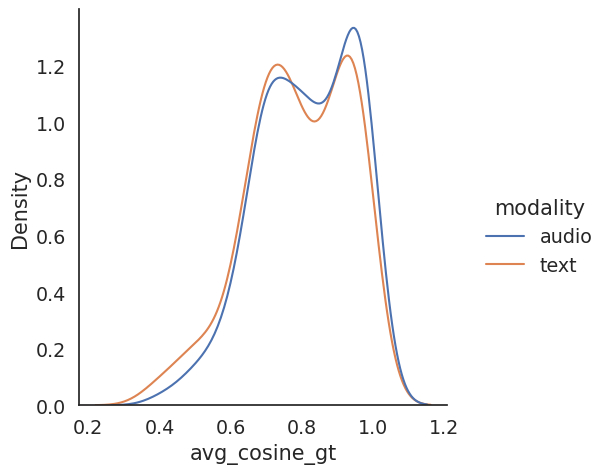

In [3255]:
sns.displot(df_bert_responses, x='avg_cosine_gt', hue='modality', kind='kde')

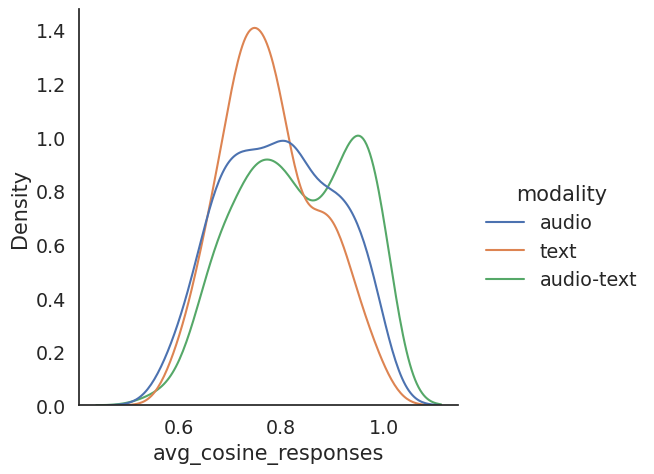

In [3165]:
sns.displot(df_bert_responses, x='avg_cosine_responses', hue='modality', kind='kde')

Separate correlation by both correct, humans, models, neither

# Show some probability distributions

In [347]:
df = df.append(last.iloc[-1], ignore_index=True)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
trial_index = 35
sns.histplot(transcript_responses[trial_index], stat="probability")
plt.title(f'Correct word: {all_words[trial_index]}')


In [ ]:
sns.histplot(transcript_responses[45])

In [ ]:
all_words[35]

In [ ]:
import seaborn as sns

In [ ]:
transcript_responses[26]

In [ ]:
sns.histplot(transcript_responses[26])

In [ ]:
for k, v in transcript_responses.items():
    print (len(v))

In [ ]:
results

In [ ]:
accuracy_stack

In [ ]:
critical_trials.response.iloc[0]

In [ ]:
df.apply(lambda x: ast.literal_eval(x))

In [155]:
dist.sum()

tensor(1.0000)

In [ ]:
[d.get('Q0') for d in df_results.response]

In [ ]:
task = 'black' # replace this string with those above

# set directories
base_dir = '/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavioral/'
# narratives_dir = '/dartfs/rc/lab/D/DBIC/DBIC/archive/narratives'

gentle_dir = os.path.join(base_dir, 'stimuli', 'gentle')
preproc_dir = os.path.join(base_dir, 'stimuli', 'preprocessed')

task_out_dir = os.path.join(preproc_dir, task)

if not os.path.exists(task_out_dir):
    os.makedirs(task_out_dir)